In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json

plt.style.use('plot_style.txt')

2023-04-19 09:30:46.287080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
final_aggressive_results, final_aggressive_results_mean, final_aggressive_results_median, final_aggressive_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_aggressive_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)
final_conservative_results, final_conservative_results_mean, final_conservative_results_median, final_conservative_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_conservative_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)

2023-04-19 09:33:22.357548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Run 8 is a good example of model misfit
run = 8
with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_true_location_means.pkl", "rb") as fp:
    true_location_means = pickle.load(fp)

with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_trick_location_means.pkl", "rb") as fp:
    trick_location_means = pickle.load(fp)

with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_true_location_vars.pkl", "rb") as fp:
    true_location_vars = pickle.load(fp)

with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_trick_location_vars.pkl", "rb") as fp:
    trick_location_vars = pickle.load(fp)

with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_true_location_trajectory_observations.pkl", "rb") as fp:
    true_location_traj = pickle.load(fp)

with open(f"../results/15-04-23/gsbp_aggressive_fully_consistent/data/run_{run}_trick_location_trajectory_observations.pkl", "rb") as fp:
    trick_location_traj = pickle.load(fp)

true_location_ineq_means = tf.squeeze(true_location_means[INEQUALITY_CONSTRAINT_ONE])
true_location_ineq_stds = tf.sqrt(tf.squeeze(true_location_vars[INEQUALITY_CONSTRAINT_ONE]))
true_location_ineq_traj = tf.squeeze(true_location_traj[INEQUALITY_CONSTRAINT_ONE])
true_location_eq_one_means = tf.squeeze(true_location_means[EQUALITY_CONSTRAINT_ONE])
true_location_eq_one_stds = tf.sqrt(tf.squeeze(true_location_vars[EQUALITY_CONSTRAINT_ONE]))
true_location_eq_one_traj = tf.squeeze(true_location_traj[EQUALITY_CONSTRAINT_ONE])
true_location_eq_two_means = tf.squeeze(true_location_means[EQUALITY_CONSTRAINT_TWO])
true_location_eq_two_stds = tf.sqrt(tf.squeeze(true_location_vars[EQUALITY_CONSTRAINT_TWO]))
true_location_eq_two_traj = tf.squeeze(true_location_traj[EQUALITY_CONSTRAINT_TWO])

trick_location_ineq_means = tf.squeeze(trick_location_means[INEQUALITY_CONSTRAINT_ONE])
trick_location_ineq_stds = tf.sqrt(tf.squeeze(trick_location_vars[INEQUALITY_CONSTRAINT_ONE]))
trick_location_ineq_traj = tf.squeeze(trick_location_traj[INEQUALITY_CONSTRAINT_ONE])
trick_location_eq_one_means = tf.squeeze(trick_location_means[EQUALITY_CONSTRAINT_ONE])
trick_location_eq_one_stds = tf.sqrt(tf.squeeze(trick_location_vars[EQUALITY_CONSTRAINT_ONE]))
trick_location_eq_one_traj = tf.squeeze(trick_location_traj[EQUALITY_CONSTRAINT_ONE])
trick_location_eq_two_means = tf.squeeze(trick_location_means[EQUALITY_CONSTRAINT_TWO])
trick_location_eq_two_stds = tf.sqrt(tf.squeeze(trick_location_vars[EQUALITY_CONSTRAINT_TWO]))
trick_location_eq_two_traj = tf.squeeze(trick_location_traj[EQUALITY_CONSTRAINT_TWO])

Text(0.5, 0.98, 'GPs At True Minimum')

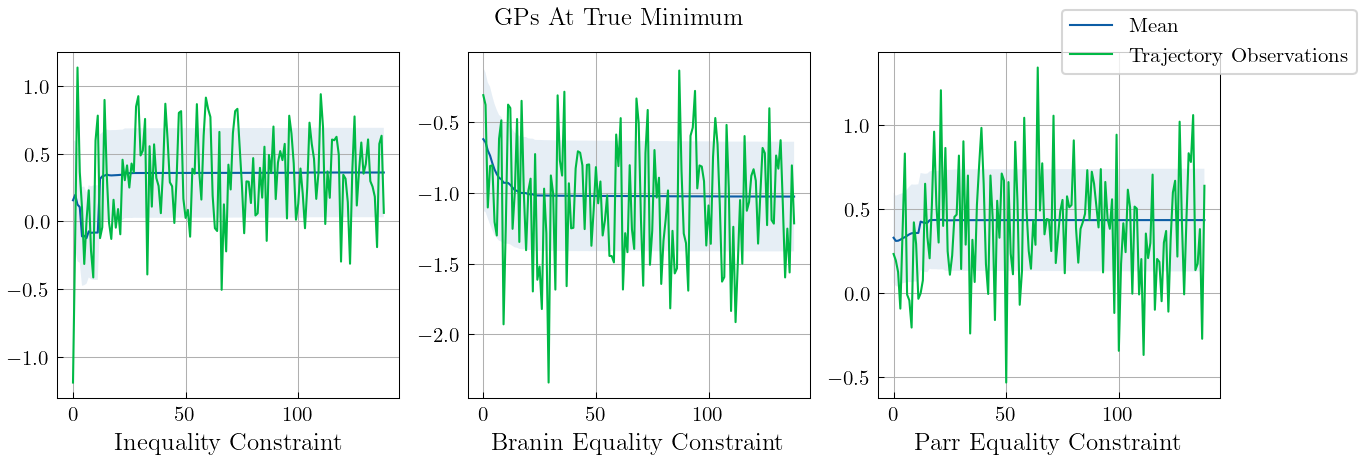

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))

iters = [i for i in range(139)]
ax1.plot(iters, true_location_ineq_means, label="Mean")
ax1.plot(iters, true_location_ineq_traj, label="Trajectory Observations")
ax1.fill_between(iters, true_location_ineq_means+true_location_ineq_stds, true_location_ineq_means-true_location_ineq_stds, alpha=0.1, linestyle='-', linewidth=2)
ax1.set_xlabel("Inequality Constraint")
ax2.plot(iters, true_location_eq_one_means)
ax2.plot(iters, true_location_eq_one_traj)
ax2.fill_between(iters, true_location_eq_one_means+true_location_eq_one_stds, true_location_eq_one_means-true_location_eq_one_stds, alpha=0.1, linestyle='-', linewidth=2)
ax2.set_xlabel("Branin Equality Constraint")
ax3.plot(iters, true_location_eq_two_means)
ax3.plot(iters, true_location_eq_two_traj)
ax3.fill_between(iters, true_location_eq_two_means+true_location_eq_two_stds, true_location_eq_two_means-true_location_eq_two_stds, alpha=0.1, linestyle='-', linewidth=2)
ax3.set_xlabel("Parr Equality Constraint")
fig.legend()
fig.suptitle("GPs At True Minimum")

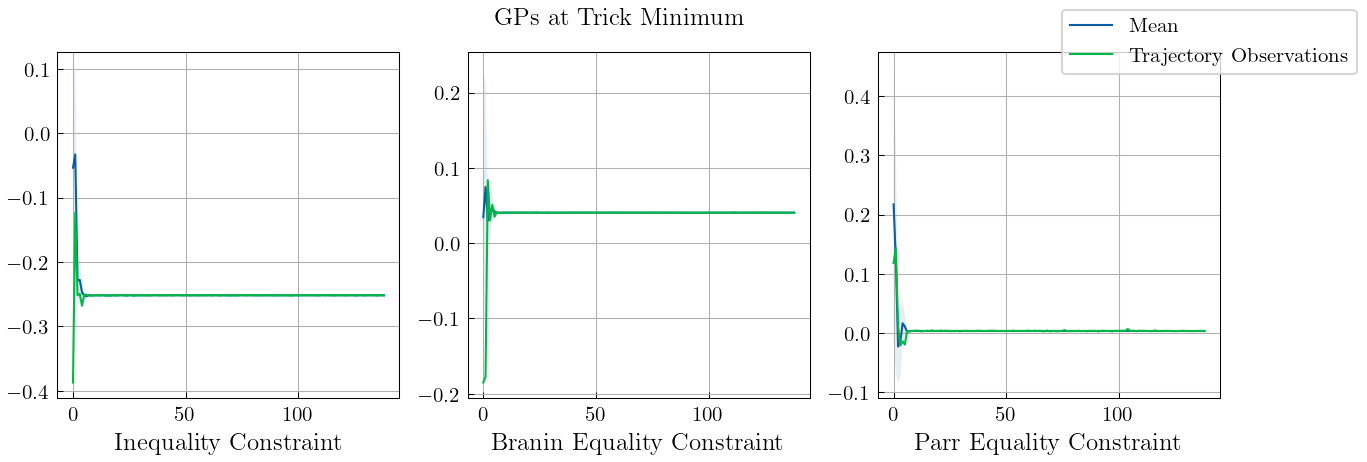

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))

iters = [i for i in range(139)]
ax1.plot(iters, trick_location_ineq_means, label="Mean")
ax1.plot(iters, trick_location_ineq_traj, label="Trajectory Observations")
ax1.fill_between(iters, trick_location_ineq_means+trick_location_ineq_stds, trick_location_ineq_means-trick_location_ineq_stds, alpha=0.1, linestyle='-', linewidth=2)
ax1.set_xlabel("Inequality Constraint")
ax2.plot(iters, trick_location_eq_one_means)
ax2.plot(iters, trick_location_eq_one_traj)
ax2.fill_between(iters, trick_location_eq_one_means+trick_location_eq_one_stds, trick_location_eq_one_means-trick_location_eq_one_stds, alpha=0.1, linestyle='-', linewidth=2)
ax2.set_xlabel("Branin Equality Constraint")
ax3.plot(iters, trick_location_eq_two_means)
ax3.plot(iters, trick_location_eq_two_traj)
ax3.fill_between(iters, trick_location_eq_two_means+trick_location_eq_two_stds, trick_location_eq_two_means-trick_location_eq_two_stds, alpha=0.1, linestyle='-', linewidth=2)
ax3.set_xlabel("Parr Equality Constraint")
fig.suptitle("GPs at Trick Minimum")
fig.legend()

In [137]:
np.where(true_location_ineq_traj <= 0)

(array([  0,   1,   5,   8,   9,  12,  13,  16,  17,  19,  21,  33,  45,
         52,  63,  64,  66,  68,  76,  86, 103, 112, 119, 123, 135]),)

In [141]:
np.where(np.abs(true_location_eq_one_traj) <= 0.01)

(array([], dtype=int64),)

In [142]:
np.where(np.abs(true_location_eq_two_traj) <= 0.01)

(array([  6,  12,  42, 106, 109, 129]),)

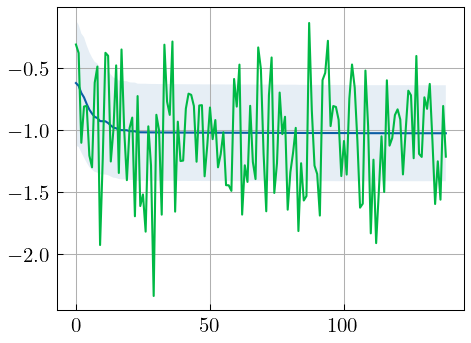

In [133]:
plt.plot(iters, true_location_eq_one_means)
plt.plot(iters, true_location_eq_one_traj)
plt.fill_between(iters, true_location_eq_one_means+true_location_eq_one_stds, true_location_eq_one_means-true_location_eq_one_stds, alpha=0.1, linestyle='-', linewidth=2)

In [21]:
true_location_means

{'INEQUALITY_CONSTRAINT_ONE': [<tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.15671377]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.19677376]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.12485795]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.10656327]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.11004546]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.1059306]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.12261914]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.07233602]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.08371112]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.08222813]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.08206262]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.08179494]]])>,
  <tf.Tensor: shape=(1, 1, 1

In [13]:
print(final_aggressive_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951]


In [15]:
import json

In [27]:
run = 12
with open(f"slack_optim/data/run_{run}_results.json", "rb") as fp:
    data = json.load(fp)

In [30]:
data['C'][:32]

[[117.334, 0],
 [332.976, 1450.88],
 [290.221, 0],
 [135.577, 1808.02],
 [0, 706.535],
 [0, 0],
 [49.3957, 0],
 [11.0784, 0],
 [122.897, 789.429],
 [125.798, 0],
 [74.6829, 0],
 [81.3329, 15.1702],
 [217.677, 0],
 [157.894, 1564.9],
 [124.354, 12.5449],
 [0, 0],
 [306.603, 0],
 [0, 424.289],
 [76.969, 0.000280099],
 [16.1261, 23.199],
 [150.313, 0],
 [286.266, 274.048],
 [162.514, 292.474],
 [138.819, 0],
 [270.648, 0],
 [145.77, 0],
 [161.85, 0],
 [189.251, 0],
 [523.696, 745.815],
 [147.03, 0],
 [1432.73, 4052.16],
 [1422.65, 2915.91]]

In [31]:
run = 11
with open(f"slack_optim/data/run_{run}_results.json", "rb") as fp:
    data = json.load(fp)

In [32]:
data['C'][:32]

[[215.85, 0],
 [185.019, 44.7298],
 [65.2668, 0],
 [163.897, 0],
 [141.075, 0],
 [3.51404e-05, 0],
 [135.15, 967.824],
 [180.383, 0],
 [70.1207, 641.733],
 [8.23836, 1123.01],
 [101.281, 0],
 [62.8549, 0],
 [224.552, 1730.04],
 [330.176, 1482.35],
 [134.758, 0],
 [66.913, 0],
 [4.5113, 0],
 [64.9765, 241.764],
 [155.412, 0],
 [83.2732, 0],
 [133.155, 0],
 [74.3609, 115.986],
 [15.5805, 3.87353],
 [15.1213, 764.907],
 [174.992, 0],
 [1.48794, 0],
 [66.9861, 0.0234016],
 [81.1509, 0],
 [125.085, 168.914],
 [120.039, 263.14],
 [138.858, 0],
 [4.5113, 0]]